In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

alpha = 0.1
gamma = 0.99
num_simulations = 2
num_iterations = 10

state_columns = ['MAP', 'diastolic_bp', 'systolic_bp', 'urine', 'ALT', 'AST', 'lactic_acid', 'serum_creatinine', 'p_f_ratio', 'GCS_total']
action_columns = ['fluid_boluses', 'vasopressors']

'''
def calculate_reward(cur_SOFA, next_SOFA, cur_MAP, next_MAP):
    c0 = -0.025
    c1 = -0.125
    c2 = 0.4
    reward = torch.where(cur_SOFA == next_SOFA, c0, 0)
    map_reward = torch.where((cur_MAP == 1) & (next_MAP == 1), 0,
                    torch.where((cur_MAP == 0) & (next_MAP == 0), -1,
                    torch.where((cur_MAP == 1) & (next_MAP == 0), -1,
                    torch.where((cur_MAP == 0) & (next_MAP == 1), 1, 0))))
    return reward + c1 * (next_SOFA - cur_SOFA) + c2 * map_reward
'''
def calculate_reward(cur_SOFA, next_SOFA, cur_MAP, next_MAP):
    reward = 0
    c0 = -0.025
    c1 = -0.125
    c2 = 0.4
    map_reward = 0
    if cur_SOFA == next_SOFA and next_SOFA > 0:
        reward += c0
    if cur_MAP == 3 and next_MAP == 3: #MAP stays at normal level
        map_reward = 0
    elif cur_MAP == next_MAP: #MAP stays at low level
        map_reward = (-3 + cur_MAP) * 0.5
    elif cur_MAP > next_MAP: #MAP deteriorates
        map_reward = (next_MAP - cur_MAP) * (4 - cur_MAP) * 0.8
    elif cur_MAP < next_MAP: #MAP improves
        map_reward = next_MAP - cur_MAP
    return reward + c1 * (next_SOFA - cur_SOFA) + c2 * map_reward
'''
def calculate_sofa_score(MAP, dbp, sbp, urine, ALT, AST, lactic_acid, serum_creatinine, p_f_ratio, GCS_total):
    cardiovascular_score = torch.where(MAP == 0, 1, 0)
    respitory_score = torch.where(p_f_ratio != 1, 2, 0)
    renal_score = serum_creatinine
    renal_score = torch.where(urine == 1, torch.max(renal_score, torch.tensor(3.0)), renal_score)
    renal_score = torch.where(urine == 0, torch.max(renal_score, torch.tensor(4.0)), renal_score)
    liver_score = torch.where((ALT > 0) & (AST > 0), 1, 0)
    liver_score = torch.where((ALT > 1) | (AST > 1), 2, liver_score)
    neuro_score = torch.where(GCS_total == 0, 4,
                   torch.where(GCS_total == 1, 3,
                   torch.where(GCS_total == 2, 2, 0)))
    lactic_acid_score = torch.where(lactic_acid > 0, 2, 0)
    return cardiovascular_score + respitory_score + renal_score + liver_score + neuro_score + lactic_acid_score
'''
def calculate_sofa_score(MAP, dbp, sbp, urine, ALT, AST, lactic_acid, serum_creatinine, p_f_ratio, GCS_total):
    cardiovascular_score = 0
    if MAP < 3:
        cardiovascular_score = 1

    respitory_score = 0
    if p_f_ratio == 0:
        respitory_score = 4
    elif p_f_ratio == 1:
        respitory_score = 3
    elif p_f_ratio == 2:
        respitory_score = 2
    else:
        respitory_score = 1

    renal_score = serum_creatinine

    #divide daily urine output standards by 6 as the data is 4 hour interval
    if urine == 1:
        renal_score = max(renal_score, 3)
    if urine == 0:
        renal_score = max(renal_score, 4)

    #since bilirubin is not available, use ALT and AST to calculate liver score
    liver_score = 0
    if (ALT > 0 and AST > 0):
        liver_score = 1
    if (ALT > 1 or AST > 1):
        liver_score = 2
    if (ALT > 2 or AST > 2):
        liver_score = 3

    neuro_score = 0
    if GCS_total == 0:
        neuro_score = 4
    elif GCS_total == 1:
        neuro_score = 3
    elif GCS_total  == 2:
        neuro_score = 2
    elif GCS_total == 3:
        neuro_score = 1

    lactic_acid_score = 0
    if lactic_acid > 0:
        lactic_acid_score = 2

    return cardiovascular_score + respitory_score + renal_score + liver_score + neuro_score + lactic_acid_score


df = pd.read_csv('binned_df.csv')
seed = 42
np.random.seed(seed)
train_ratio = 0.8
num_patients = df['PatientID'].nunique()
num_train_samples = int(num_patients * train_ratio)
train_ids = np.random.choice(num_patients, num_train_samples, replace=False)
train_df = df[df["PatientID"].isin(train_ids)].reset_index(drop=True)
test_df = df[~df["PatientID"].isin(train_ids)].reset_index(drop=True)
print(f'Train Data: {train_df.shape}')
print(f'Test Data: {test_df.shape}')

def create_transitions(df):
    df_size = len(df) / 48 * 47
    print(df_size)
    print(type(df_size))
    state_cols = [f"state_{i}" for i in range(len(state_columns + action_columns))]
    X = torch.zeros((int(df_size), len(state_columns) + len(action_columns)), device="cuda")
    y = torch.zeros((int(df_size), len(state_columns)), device="cuda")
    i = 0
    for patient in df['PatientID'].unique():
        patient_records = df[df['PatientID'] == patient].reset_index(drop=True)
        for t in range(len(patient_records) - 1):
            current_state = torch.tensor(patient_records.iloc[t][state_columns + action_columns].values, device="cuda")
            next_state = torch.tensor(patient_records.iloc[t + 1][state_columns].values, device="cuda")
            X[i] = current_state
            y[i] = next_state
            i+=1
    #for i in range(len(df) - 1):
        #current_state = torch.tensor(df.iloc[i][state_columns + action_columns].values, device="cuda")
        #next_state = torch.tensor(df.iloc[i + 1][state_columns].values, device="cuda")
        #X[i] = current_state
        #y[i] = next_state
    return pd.DataFrame(X.cpu().numpy(), columns=state_columns + action_columns), pd.DataFrame(y.cpu().numpy(), columns=state_columns)

X, y = create_transitions(train_df)

knn_models = {col: KNeighborsClassifier(n_neighbors=20) for col in state_columns}
for col in state_columns:
    knn_models[col].fit(X, y[col])

state_dict = {tuple(row): idx for idx, row in enumerate(train_df[state_columns].drop_duplicates().values)}
action_dict = {tuple(row): idx for idx, row in enumerate(train_df[action_columns].drop_duplicates().values)}
inverse_state_dict = {v: k for k, v in state_dict.items()}
inverse_action_dict = {v: k for k, v in action_dict.items()}

q_table = torch.zeros((len(state_dict), len(action_dict)), device="cuda")


Train Data: (150144, 15)
Test Data: (37536, 15)
147016.0
<class 'float'>


In [10]:
print(len(state_dict))

10912


In [ ]:
#initialise Q value with training set
q_table = torch.zeros((len(state_dict), len(action_dict)), device="cuda")
visit_counts = torch.zeros_like(q_table)
i = 0
print(len(train_df['PatientID'].unique()))
for patient in train_df['PatientID'].unique():
    print(i)
    i+=1
    patient_records = train_df[train_df['PatientID'] == patient].reset_index(drop=True)
    for t in range(len(patient_records) - 1):
        current_row = torch.tensor(patient_records.iloc[t][state_columns].values, device="cuda")
        next_row = torch.tensor(patient_records.iloc[t + 1][state_columns].values, device="cuda")
        action = torch.tensor(patient_records.iloc[t][action_columns].values, device="cuda")

        current_state_index = state_dict[tuple(current_row.cpu().numpy())]
        action_index = action_dict[tuple(action.cpu().numpy())]

        reward = calculate_reward(
            calculate_sofa_score(*current_row),
            calculate_sofa_score(*next_row),
            current_row[0],
            next_row[0]
        )
        q_table[current_state_index, action_index] += reward
        visit_counts[current_state_index, action_index] += 1
q_table = torch.where(visit_counts != 0, q_table / visit_counts, torch.zeros_like(q_table))


3128
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

In [ ]:
q_table_df = pd.DataFrame(q_table.cpu().numpy())
q_table_df.to_csv("q_table_init.csv")

In [4]:
def find_closest_index(input_tuple):
    closest_index = None
    min_distance = float('inf')

    for value, index in state_dict.items():
        distance = np.linalg.norm(np.array(value) - np.array(input_tuple))

        if distance < min_distance:
            min_distance = distance
            closest_index = index

    return closest_index

In [22]:
diffs = []

In [6]:
print(q_table)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')


In [ ]:
q_init_backup = q_table.clone()

In [20]:
def dyna_q_train(train_df, num_iterations, num_simulations):
    global q_table
    for iteration in range(num_iterations):
        print(f"Iteration {iteration + 1}/{num_iterations}")
        q_backup = q_table.clone()
        pid = 0
        for patient in train_df['PatientID'].unique():
            patient_records = train_df[train_df['PatientID'] == patient].reset_index(drop=True)
            if pid % 100 == 0:
                print(pid)
            pid+=1
            for t in range(len(patient_records) - 1):
                current_row = torch.tensor(patient_records.iloc[t][state_columns].values, device="cuda")
                next_row = torch.tensor(patient_records.iloc[t + 1][state_columns].values, device="cuda")
                action = torch.tensor(patient_records.iloc[t][action_columns].values, device="cuda")

                current_state_index = state_dict[tuple(current_row.cpu().numpy())]
                action_index = action_dict[tuple(action.cpu().numpy())]

                reward = calculate_reward(
                    calculate_sofa_score(*current_row),
                    calculate_sofa_score(*next_row),
                    current_row[0],
                    next_row[0]
                )

                next_state_index = state_dict[tuple(next_row.cpu().numpy())]
                best_next_q = torch.max(q_table[next_state_index])

                q_table[current_state_index, action_index] += alpha * (
                    reward + gamma * best_next_q - q_table[current_state_index, action_index])

                for _ in range(num_simulations):
                    sim_state_index = random.choice(list(state_dict.values()))
                    sim_action_index = random.choice(list(action_dict.values()))

                    sim_state = torch.tensor(inverse_state_dict[sim_state_index], device="cuda")
                    sim_action = torch.tensor(inverse_action_dict[sim_action_index], device="cuda")

                    sim_next_state = []
                    for col in state_columns:
                        sim_next_state.append(knn_models[col].predict(
                            pd.concat([pd.Series(sim_state.cpu().numpy(), index=state_columns),
                                       pd.Series(sim_action.cpu().numpy(), index=action_columns)], axis=0)
                            .to_frame().T).item())

                    sim_next_state = torch.tensor(sim_next_state, device="cuda")
                    sim_reward = calculate_reward(
                        calculate_sofa_score(*sim_state),
                        calculate_sofa_score(*sim_next_state),
                        sim_state[0],
                        sim_next_state[0]
                    )

                    sim_next_state_tuple = tuple(sim_next_state.cpu().numpy())
                    if sim_next_state_tuple in state_dict:
                        sim_next_state_index = state_dict[sim_next_state_tuple]
                    else:
                        sim_next_state_index = find_closest_index(sim_next_state_tuple)

                    best_sim_next_q = torch.max(q_table[sim_next_state_index])

                    q_table[sim_state_index, sim_action_index] += alpha * (
                        sim_reward + gamma * best_sim_next_q - q_table[sim_state_index, sim_action_index])

        diff = torch.mean(torch.abs(q_table - q_backup))
        diffs.append(diff.item())
        print(f"Q-table difference after iteration {iteration + 1}: {diff.item()}")



    return q_table

In [ ]:
q_table = q_init_backup.clone()

Iteration 1/5
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
Q-table difference after iteration 1: 0.057450152933597565
Iteration 2/5
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
Q-table difference after iteration 2: 0.051665738224983215
Iteration 3/5
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
Q-table difference after iteration 3: 0.04881170392036438
Iteration 4/5
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
Q-table difference after iteration 4: 0.04668880254030228
Iteration 5/5
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2

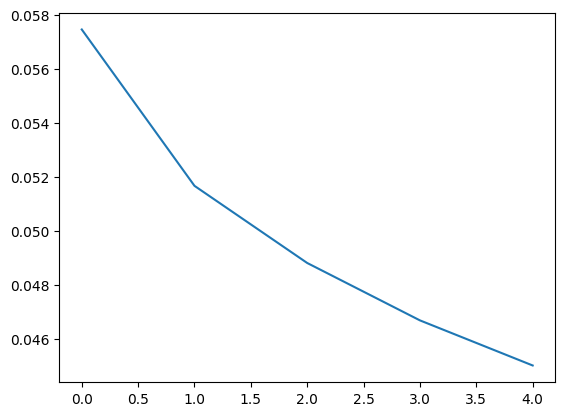

In [23]:

# Train on a subset
import matplotlib.pyplot as plt
q_table = dyna_q_train(train_df, num_iterations=5, num_simulations=1)
plt.plot(diffs)
plt.show()

In [25]:
q_table_df = pd.DataFrame(q_table.cpu().numpy())
q_table_df.to_csv("q_table_trained.csv")

In [26]:
print(diffs)

[0.057450152933597565, 0.051665738224983215, 0.04881170392036438, 0.04668880254030228, 0.045020654797554016]


In [ ]:
c_q = q_table.cpu().numpy()


In [31]:
import torch
def select_optimal_action(state_index, q_table):
    best_action_index = torch.argmax(q_table[state_index]).item()
    best_action = inverse_action_dict[best_action_index]
    return best_action

def dynaq_cumulative_reward(df):
    total_cumulative_reward = torch.tensor(0.0, device="cuda")  # Initialize cumulative reward on GPU
    rewards = []  # Store reward for each time step of each patient
    i = 0
    #print(len(df))
    print(len(df['PatientID'].unique()))
    for patient in df['PatientID'].unique():
        if i % 20 == 0:
            print(i)
        i += 1
        patient_records = df[df['PatientID'] == patient].reset_index(drop=True)
        current_state = torch.tensor(patient_records.iloc[0][state_columns].values, device="cuda")
        #print(type(current_state))
        for t in range(len(patient_records) - 1):
            state_tuple = tuple(current_state.tolist())

            if state_tuple in state_dict:
                state_idx = state_dict[state_tuple]
            else:
                state_idx = find_closest_index(state_tuple)

            # Select the best action for the current state
            action = select_optimal_action(state_idx, q_table)
            fluid, vaso = action  # Extract action components

            # Prepare input for KNN prediction
            input_data = torch.cat([current_state, torch.tensor([fluid, vaso], device="cuda")], dim=0).cpu().numpy().reshape(1, -1)
            input_data_df = pd.DataFrame(input_data, columns=['MAP', 'diastolic_bp', 'systolic_bp', 'urine', 'ALT', 'AST', 'lactic_acid', 'serum_creatinine', 'p_f_ratio', 'GCS_total', 'fluid_boluses', 'vasopressors'])
            # Predict the next state for each feature using KNN and store in a DataFrame
            predicted_next_state = pd.DataFrame()
            for col in state_columns:
                predicted_next_state[col] = knn_models[col].predict(input_data_df)

            # Convert the predicted DataFrame to a GPU tensor
            #next_state = torch.tensor(predicted_next_state.values, device="cuda")
            next_state = torch.tensor(predicted_next_state.iloc[0].values, device="cuda")
            #print(type(next_state))
            # Calculate the SOFA score and MAP values for current and next states
            #print(*current_state)
            cur_sofa = calculate_sofa_score(*current_state)
            #print('cur')
            #print(cur_sofa)
            next_sofa = calculate_sofa_score(*next_state)
            #print(next_sofa)
            cur_map = current_state[0]
            next_map = next_state[0]

            # Calculate the reward for transitioning to the next state
            reward = calculate_reward(cur_sofa, next_sofa, cur_map, next_map)

            # Update cumulative reward and add to rewards list
            total_cumulative_reward += reward
            rewards.append(reward)  # Convert to Python float for storage in list

            # Set the next state as the current state for the next time point
            current_state = next_state

    # Return total cumulative reward and the rewards per time step
    return total_cumulative_reward, rewards


In [32]:
print(len(test_df))
r3, rl3 = dynaq_cumulative_reward(test_df)
print("total cumulative reward (dyna Q) per patient with SOFA score reward:", r3 / 782)
#plt.hist(rl3)
#plt.show()

37536
782
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
540
560
580
600
620
640
660
680
700
720
740
760
780
total cumulative reward (dyna Q) per patient with SOFA score reward: tensor(-0.5594, device='cuda:0')


In [33]:
def no_action_cumulative_reward(df):
    total_cumulative_reward = torch.tensor(0.0, device="cuda")  # Initialize cumulative reward on GPU
    rewards = []  # Store reward for each time step of each patient
    i = 0
    #print(len(df))
    print(len(df['PatientID'].unique()))
    for patient in df['PatientID'].unique():
        if i % 20 == 0:
            print(i)
        i += 1
        patient_records = df[df['PatientID'] == patient].reset_index(drop=True)
        current_state = torch.tensor(patient_records.iloc[0][state_columns].values, device="cuda")
        #print(type(current_state))
        for t in range(len(patient_records) - 1):
            state_tuple = tuple(current_state.tolist())

            if state_tuple in state_dict:
                state_idx = state_dict[state_tuple]
            else:
                state_idx = find_closest_index(state_tuple)

            # Select the best action for the current state
            #action = select_optimal_action(state_idx, q_table)
            #fluid, vaso = action  # Extract action components

            # Prepare input for KNN prediction
            input_data = torch.cat([current_state, torch.tensor([0, 0], device="cuda")], dim=0).cpu().numpy().reshape(1, -1)
            input_data_df = pd.DataFrame(input_data, columns=['MAP', 'diastolic_bp', 'systolic_bp', 'urine', 'ALT', 'AST', 'lactic_acid', 'serum_creatinine', 'p_f_ratio', 'GCS_total', 'fluid_boluses', 'vasopressors'])
            # Predict the next state for each feature using KNN and store in a DataFrame
            predicted_next_state = pd.DataFrame()
            for col in state_columns:
                predicted_next_state[col] = knn_models[col].predict(input_data_df)

            # Convert the predicted DataFrame to a GPU tensor
            #next_state = torch.tensor(predicted_next_state.values, device="cuda")
            next_state = torch.tensor(predicted_next_state.iloc[0].values, device="cuda")
            #print(type(next_state))
            # Calculate the SOFA score and MAP values for current and next states
            #print(*current_state)
            cur_sofa = calculate_sofa_score(*current_state)
            #print('cur')
            #print(cur_sofa)
            next_sofa = calculate_sofa_score(*next_state)
            #print(next_sofa)
            cur_map = current_state[0]
            next_map = next_state[0]

            # Calculate the reward for transitioning to the next state
            reward = calculate_reward(cur_sofa, next_sofa, cur_map, next_map)

            # Update cumulative reward and add to rewards list
            total_cumulative_reward += reward
            rewards.append(reward)  # Convert to Python float for storage in list

            # Set the next state as the current state for the next time point
            current_state = next_state

    # Return total cumulative reward and the rewards per time step
    return total_cumulative_reward, rewards

In [50]:
def random_action_cumulative_reward(df):
    total_cumulative_reward = torch.tensor(0.0, device="cuda")  # Initialize cumulative reward on GPU
    rewards = []  # Store reward for each time step of each patient
    i = 0
    #print(len(df))
    print(len(df['PatientID'].unique()))
    for patient in df['PatientID'].unique():
        if i % 20 == 0:
            print(i)
        i += 1
        patient_records = df[df['PatientID'] == patient].reset_index(drop=True)
        current_state = torch.tensor(patient_records.iloc[0][state_columns].values, device="cuda")
        #print(type(current_state))
        for t in range(len(patient_records) - 1):
            state_tuple = tuple(current_state.tolist())

            if state_tuple in state_dict:
                state_idx = state_dict[state_tuple]
            else:
                state_idx = find_closest_index(state_tuple)

            # Select the best action for the current state
            #action = select_optimal_action(state_idx, q_table)
            #fluid, vaso = action  # Extract action components
            action_idx = random.choice(list(action_dict.values()))
            #print(inverse_action_dict[action_idx])
            # Prepare input for KNN prediction
            input_data = torch.cat([current_state, torch.tensor([inverse_action_dict[action_idx][0], inverse_action_dict[action_idx][1]], device="cuda")], dim=0).cpu().numpy().reshape(1, -1)
            input_data_df = pd.DataFrame(input_data, columns=['MAP', 'diastolic_bp', 'systolic_bp', 'urine', 'ALT', 'AST', 'lactic_acid', 'serum_creatinine', 'p_f_ratio', 'GCS_total', 'fluid_boluses', 'vasopressors'])
            # Predict the next state for each feature using KNN and store in a DataFrame
            predicted_next_state = pd.DataFrame()
            for col in state_columns:
                predicted_next_state[col] = knn_models[col].predict(input_data_df)

            # Convert the predicted DataFrame to a GPU tensor
            #next_state = torch.tensor(predicted_next_state.values, device="cuda")
            next_state = torch.tensor(predicted_next_state.iloc[0].values, device="cuda")
            #print(type(next_state))
            # Calculate the SOFA score and MAP values for current and next states
            #print(*current_state)
            cur_sofa = calculate_sofa_score(*current_state)
            #print('cur')
            #print(cur_sofa)
            next_sofa = calculate_sofa_score(*next_state)
            #print(next_sofa)
            cur_map = current_state[0]
            next_map = next_state[0]

            # Calculate the reward for transitioning to the next state
            reward = calculate_reward(cur_sofa, next_sofa, cur_map, next_map)

            # Update cumulative reward and add to rewards list
            total_cumulative_reward += reward
            rewards.append(reward)  # Convert to Python float for storage in list

            # Set the next state as the current state for the next time point
            current_state = next_state

    # Return total cumulative reward and the rewards per time step
    return total_cumulative_reward, rewards

In [19]:
import torch

cumulative_reward = torch.tensor(0.0, device="cuda")
j = 0
print(len(test_df['PatientID'].unique()))
for patient_id in test_df['PatientID'].unique():
    patient_records = test_df[test_df['PatientID'] == patient_id].reset_index(drop=True)
    print(j)
    j+=1
    for t in range(len(patient_records) - 1):
        current_row = torch.tensor(patient_records.iloc[t][state_columns].values, device="cuda")
        next_row = torch.tensor(patient_records.iloc[t + 1][state_columns].values, device="cuda")
        #action = torch.tensor(patient_records.iloc[t][action_columns].values, device="cuda")

        #current_state_index = state_dict[tuple(current_row.cpu().numpy())]
        #action_index = action_dict[tuple(action.cpu().numpy())]

        reward = calculate_reward(
            calculate_sofa_score(*current_row),
            calculate_sofa_score(*next_row),
            current_row[0],
            next_row[0]
        )
        cumulative_reward += reward

cumulative_reward_value = cumulative_reward.item()

print(f"Cumulative reward following the data's policy: {cumulative_reward_value / 782}")


782
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

In [ ]:
print(state_dict)

{(1, 0, 1, 1, 1, 1, 0, 1, 0, 2): 0, (1, 1, 1, 2, 0, 1, 0, 0, 0, 2): 1, (0, 0, 1, 1, 0, 1, 0, 1, 0, 2): 2, (1, 0, 1, 1, 1, 1, 0, 0, 0, 2): 3, (1, 1, 1, 1, 0, 1, 0, 0, 0, 2): 4, (0, 0, 0, 2, 0, 1, 0, 1, 0, 2): 5, (1, 0, 1, 1, 0, 0, 0, 1, 0, 2): 6, (1, 1, 1, 2, 1, 1, 0, 0, 0, 2): 7, (1, 0, 1, 2, 0, 1, 0, 1, 0, 2): 8, (1, 1, 1, 2, 1, 1, 0, 0, 0, 0): 9, (1, 0, 1, 2, 0, 0, 0, 0, 0, 2): 10, (0, 0, 1, 1, 0, 0, 0, 1, 0, 0): 11, (0, 0, 1, 2, 0, 0, 0, 0, 0, 2): 12, (0, 0, 1, 1, 0, 1, 0, 1, 1, 1): 13, (0, 0, 0, 1, 0, 1, 0, 1, 1, 0): 14, (0, 0, 1, 1, 0, 1, 0, 1, 1, 0): 15, (1, 0, 1, 1, 0, 0, 0, 0, 0, 2): 16, (0, 0, 1, 2, 0, 0, 0, 1, 0, 1): 17, (0, 0, 1, 2, 0, 1, 0, 0, 0, 2): 18, (1, 1, 1, 2, 0, 0, 0, 0, 0, 2): 19, (0, 0, 0, 1, 0, 1, 0, 1, 0, 2): 20, (1, 0, 0, 2, 1, 1, 0, 0, 0, 2): 21, (1, 0, 1, 1, 0, 1, 0, 0, 0, 2): 22, (0, 0, 1, 0, 1, 1, 0, 1, 0, 0): 23, (0, 0, 0, 2, 0, 1, 0, 0, 0, 1): 24, (1, 0, 1, 2, 0, 1, 0, 0, 0, 2): 25, (0, 0, 1, 1, 0, 1, 0, 0, 0, 2): 26, (0, 0, 1, 2, 0, 0, 0, 1, 0, 2): 27, (

In [27]:
print(action_dict)

{(0, 0): 0, (0, 2): 1, (0, 3): 2, (0, 1): 3, (3, 0): 4, (2, 1): 5, (2, 0): 6, (3, 1): 7, (1, 0): 8, (1, 2): 9, (3, 3): 10, (2, 3): 11, (1, 1): 12, (3, 2): 13, (2, 2): 14, (1, 3): 15}


In [28]:
state_dict_df = pd.DataFrame([state_dict])  # Convert to DataFrame as a single row
state_dict_df.to_csv('state_dict.csv', index=False)

In [35]:
def get_dynaq_actions(df):
    dynaq_map = []
    dynaq_fluids = []
    dynaq_vasopressors = []
    i = 0
    #print(len(df))
    print(len(df['PatientID'].unique()))
    for patient in df['PatientID'].unique():
        if i % 20 == 0:
            print(i)
        i += 1
        patient_records = df[df['PatientID'] == patient].reset_index(drop=True)
        current_state = torch.tensor(patient_records.iloc[0][state_columns].values, device="cuda")
        #print(type(current_state))
        for t in range(len(patient_records) - 1):
            state_tuple = tuple(current_state.tolist())

            if state_tuple in state_dict:
                state_idx = state_dict[state_tuple]
            else:
                state_idx = find_closest_index(state_tuple)

            # Select the best action for the current state
            action = select_optimal_action(state_idx, q_table)
            fluid, vaso = action
            dynaq_map.append(current_state[0])
            dynaq_fluids.append(fluid)
            dynaq_vasopressors.append(vaso)

    return dynaq_map, dynaq_fluids, dynaq_vasopressors

In [36]:
dynaq_map, dynaq_fluids, dynaq_vasopressors = get_dynaq_actions(test_df)

782
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780


In [ ]:
dynaq_map, dynaq_fluids, dynaq_vasopressors

In [42]:
#MAP vs action plot
import matplotlib.pyplot as plt
import seaborn as sns

#dynaq_map = [0,0,1,2,3]
#dynaq_fluids = [3,2,0,1,0]
#dynaq_vasopressors = [2,1,0,0,0]

policy_df = pd.DataFrame()
policy_df['MAP_tier'] = torch.tensor(dynaq_map, device='cuda').to('cpu').numpy()
policy_df['dynaq_fluid'] = torch.tensor(dynaq_fluids, device='cuda').to('cpu').numpy()
policy_df['dynaq_vasopressor'] = torch.tensor(dynaq_vasopressors, device='cuda').to('cpu').numpy()

dynaq_action_counts = policy_df.groupby(["MAP_tier", "dynaq_fluid", "dynaq_vasopressor"]).size().reset_index(name="dynaq_count")

def get_action_proportion(action_count_df, policy, action_name):
    counts = action_count_df.groupby(["MAP_tier", f"{policy}_{action_name}"])[f"{policy}_count"].sum()
    #print(counts)
    proportions = counts.groupby(level=0, group_keys=False).apply(lambda x: x ).reset_index(name='proportion')

    proportions = proportions.rename(columns={f"{policy}_{action_name}": action_name})
    #print(proportions)
    return proportions

<Axes: xlabel='Dyna-Q - Vasopressors', ylabel='proportion'>

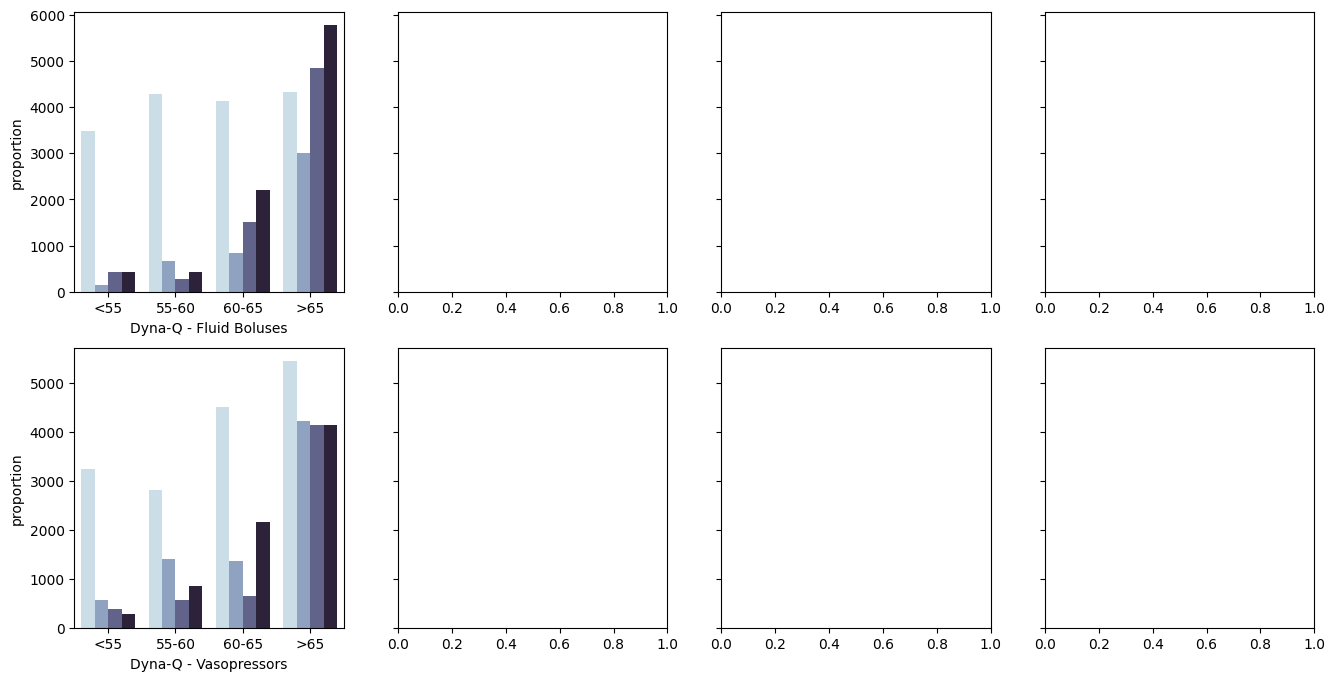

In [43]:
dynaq_fluid_proportions = get_action_proportion(dynaq_action_counts, "dynaq", "fluid")
dynaq_vaso_proportions = get_action_proportion(dynaq_action_counts, "dynaq", "vasopressor")
#map MAP and actions from 0,1,2,3 to text
fluid_bolus_order = {0: "[0, 250)", 1: "[250, 500)", 2: "[500, 1000)", 3: ">= 1000"}
vasopressor_order = {0: "0", 1: "(0, 8.4)", 2: "[8.4, 20.28)", 3: ">= 20.28"}
map_tier_order = bl = {0: "<55", 1: "55-60", 2: "60-65", 3: ">65"}
dynaq_fluid_proportions['Fluid Boluses'] = dynaq_fluid_proportions['fluid'].map(fluid_bolus_order)
dynaq_fluid_proportions['Dyna-Q - Fluid Boluses'] = dynaq_fluid_proportions['MAP_tier'].map(map_tier_order)
dynaq_vaso_proportions['Vasopressors'] = dynaq_vaso_proportions['vasopressor'].map(vasopressor_order)
dynaq_vaso_proportions['Dyna-Q - Vasopressors'] = dynaq_vaso_proportions['MAP_tier'].map(map_tier_order)
dynaq_fluid_proportions.drop('fluid', axis='columns', inplace=True)
dynaq_vaso_proportions.drop('vasopressor', axis='columns', inplace=True)

#print(dynaq_fluid_proportions)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), sharey='row')
sns.barplot(data=dynaq_fluid_proportions, x='Dyna-Q - Fluid Boluses', y='proportion', hue='Fluid Boluses',
            palette="ch:s=.25,rot=-.25", ax=axes[0, 0], legend=None)
sns.barplot(data=dynaq_vaso_proportions, x='Dyna-Q - Vasopressors', y='proportion', hue='Vasopressors',
                palette="ch:s=.25,rot=-.25", ax=axes[1, 0], legend=None)

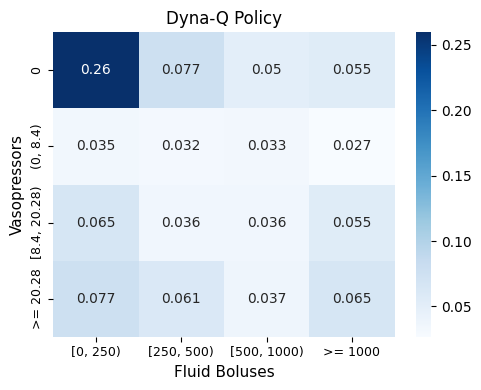

<Figure size 640x480 with 0 Axes>

In [41]:
#plot action heatmap
#dynaq_actions = [0,1,4,2,5,3,15]
action_count_matrix = np.zeros((4, 4))
for i in range(len(dynaq_fluids)):
    fluid = dynaq_fluids[i]
    vaso = dynaq_vasopressors[i]
    action_count_matrix[fluid,vaso] += 1
action_distribution_dynaq = action_count_matrix / len(dynaq_fluids)
#fluid_categories = ['0', '250', '500', '1000']
#vasopressor_categories = ['0', '1e-6', '8.4', '20.28']
fluid_categories = ['[0, 250)', '[250, 500)', '[500, 1000)', '>= 1000']  # Sorted fluid boluses
vasopressor_categories = ['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28']  # Sorted vasopressors
plt.figure(figsize=(5, 4))
sns.heatmap(action_distribution_dynaq, annot=True, cmap="Blues", xticklabels=fluid_categories, yticklabels=vasopressor_categories)
plt.title('Dyna-Q Policy')
plt.xlabel('Fluid Boluses', fontsize=11)
plt.ylabel('Vasopressors', fontsize=11)
plt.tick_params(labelsize=9)
plt.tight_layout()
plt.show()
plt.savefig('heatmap.png')